# MODELOS

## LIBRERÍAS

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import numpy as np

In [2]:
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet

In [3]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import r2_score

## LECTURA DE LOS DATOS

In [4]:
table_diaria = pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/Practices/EXAM/Exam_data/datos_diarios.parquet')
datos_diarios = table_diaria.to_pandas()

In [5]:
table_horaria = pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/Practices/EXAM/Exam_data/datos_horarios.parquet')
datos_horarios = table_horaria.to_pandas()

## DESCOMPOSICIÓN STL

STL es un método para la descomposición de series temporales. Sus siglas corresponden a *Seasonal and Trend decomposition using Loess*.

#### DATOS HORARIOS

Podemos observar que los datos no tienen tendencia y, claramente vemos que la serie tiene componente estacional en los meses entre verano y otoño más o menos.

#### DATOS DIARIOS

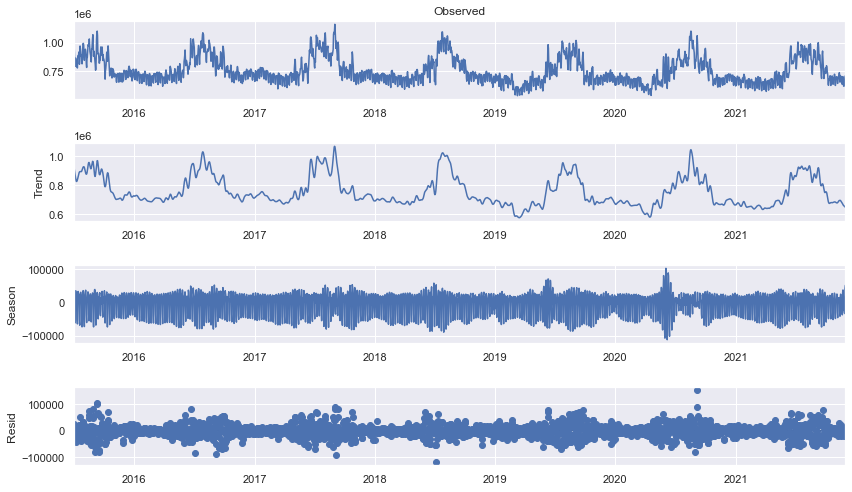

In [6]:
sns.set(rc={'figure.figsize':(12, 7)})

stl = STL(datos_diarios)
res = stl.fit()
fig = res.plot()

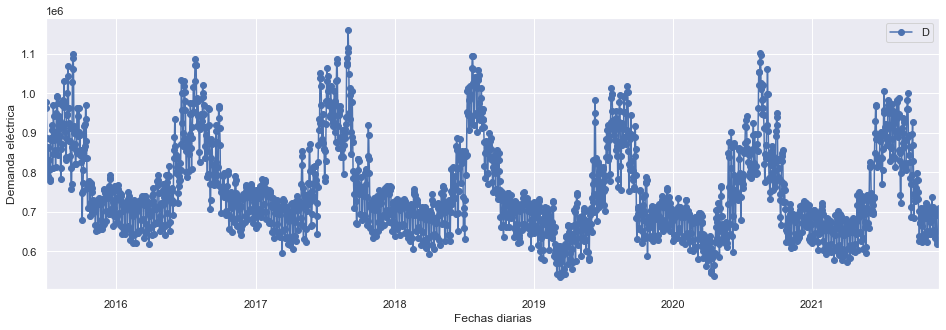

In [7]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_diarios.plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

Debido a que la serie se comporta de manera muy parecida año tras año, vamos a considerar los datos a partir de 2019 con el fin de reducir el número de datos.

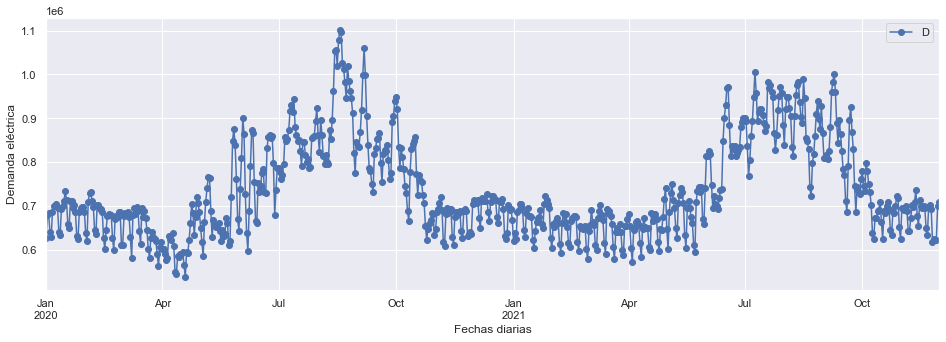

In [46]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_diarios["2020":].plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

In [9]:
datos_diarios_d = datos_diarios.to_period("D")

Vamos a considerar nuestros datos a partir del año 2020 ya que la serie temporal se comporta de forma muy parecida año tras año. De esta manera reducimos la cantidad de datos.

Las dimensiones del dataset de training es: 680 y 20


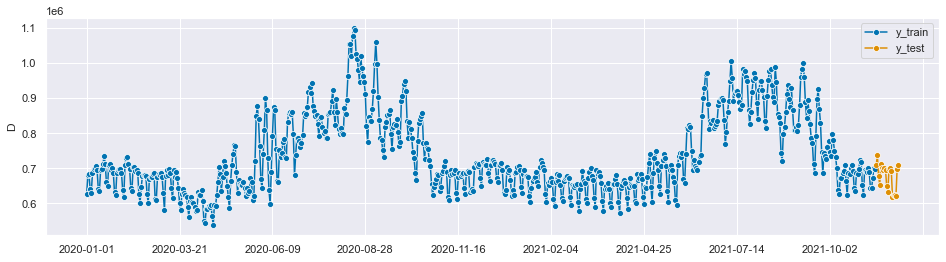

In [10]:
y_train_diario, y_test_diario = temporal_train_test_split(y = datos_diarios_d["2020":]["D"].astype('float64'), test_size=20)
plot_series(y_train_diario, y_test_diario, labels=["y_train", "y_test"])
print("Las dimensiones del dataset de training es:" ,y_train_diario.shape[0], "y", y_test_diario.shape[0])

### MODELO BASE

El modelo base del que haremos uso será el método ingenuo (Naive). Este método es utilizado en series temporales con componente estacional. Sencillamente, si por ejemplo queremos predecir datos trimestrales, la predicción del trimestre que queramos predecir tomará el valor del trimestre anterior. 

In [11]:
fh = np.arange(1, 21)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

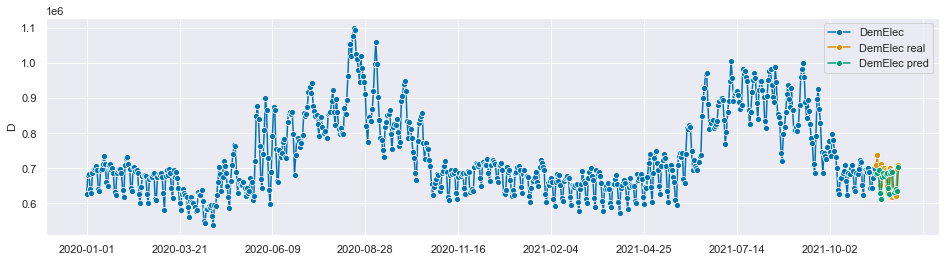

In [12]:
Met_Naive = NaiveForecaster(strategy="last", sp=365)

Met_Naive.fit(y_train_diario)

# step 5: querying predictions
pred_Naive = Met_Naive.predict(fh)

plot_series(y_train_diario, y_test_diario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])

Vamos a ampliar la predicción para verla mejor.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

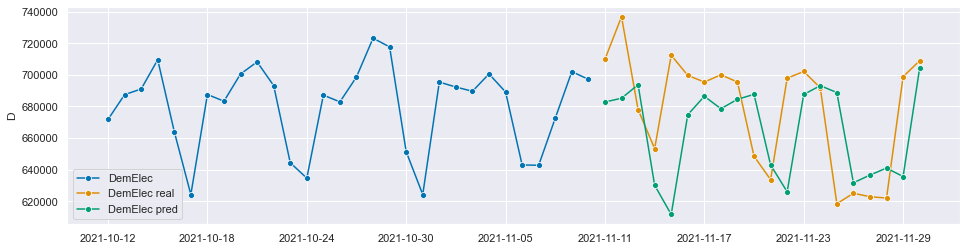

In [13]:
plot_series(y_train_diario[650:], y_test_diario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])

La predicción, a simple vista, vemos que falla mucho al principio. Sin embargo, a medida que avanza el tiempo acierta cada vez más. Para tener una visión estadística de la predicción, hallaremos el error cuadrático medio.

In [14]:
MAPE_NAIVE = mean_absolute_percentage_error(y_test_diario, pred_Naive)
MAPE_NAIVE

0.04474190096893744

In [15]:
rmse_NAIVE = MeanSquaredError(square_root=True)
rmse_NAIVE =rmse_NAIVE(y_test_diario, pred_Naive)
rmse_NAIVE

40109.40160486067

In [16]:
r2_NAIVE = r2_score(y_test_diario, pred_Naive)
r2_NAIVE

-0.24966569074233136

Este será nuestro modelo base y, a partir de aquí, todos los modelos que vayamos considerando deberán mejorar los resultados que acabamos de obtener.

## MODELO ETS

In [17]:
ETS_diario = AutoETS(auto=True, sp=7, n_jobs=-1) 

In [18]:
ETS_diario.fit(y_train_diario)
print(ETS_diario.summary())

                                 ETS Results                                  
Dep. Variable:                      D   No. Observations:                  680
Model:                       ETS(MNM)   Log Likelihood               -7864.007
Date:                Thu, 30 Dec 2021   AIC                          15750.014
Time:                        11:31:42   BIC                          15799.757
Sample:                    01-01-2020   HQIC                         15769.268
                         - 11-10-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.049     20.429      0.000       0.904       1.096
smoothing_seasonal  9.899e-06      0.020      0.001      1.000      -0.038       0.038
initial_level       

In [19]:
ETS_diario_pred = ETS_diario.predict(fh)
print(ETS_diario_pred)

2021-11-11    697069.427908
2021-11-12    688957.546782
2021-11-13    645685.199371
2021-11-14    625531.817336
2021-11-15    685157.969714
2021-11-16    694863.014040
2021-11-17    697199.648369
2021-11-18    697069.427908
2021-11-19    688957.546782
2021-11-20    645685.199371
2021-11-21    625531.817336
2021-11-22    685157.969714
2021-11-23    694863.014040
2021-11-24    697199.648369
2021-11-25    697069.427908
2021-11-26    688957.546782
2021-11-27    645685.199371
2021-11-28    625531.817336
2021-11-29    685157.969714
2021-11-30    694863.014040
Freq: D, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

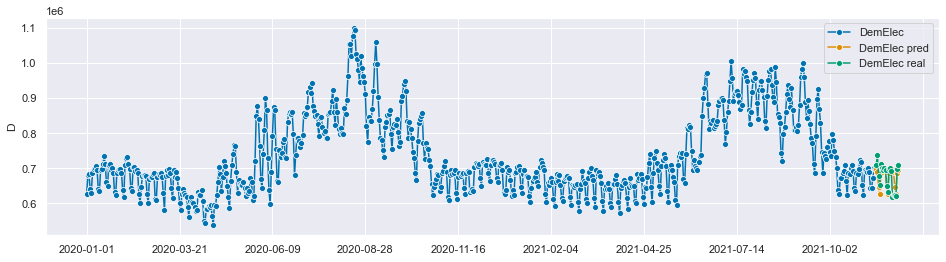

In [20]:
plot_series(y_train_diario, ETS_diario_pred, y_test_diario, labels=["DemElec", "DemElec pred", "DemElec real"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

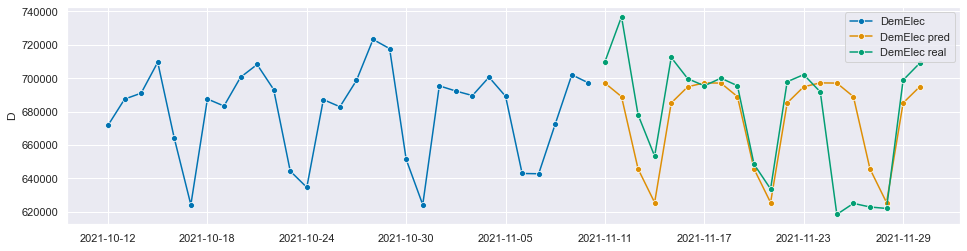

In [21]:
plot_series(y_train_diario[650:], ETS_diario_pred, y_test_diario, labels=["DemElec", "DemElec pred", "DemElec real"])

#### MÉTRICAS

Vemos que la predicción es realmente mala. Veamos cuales son los valores de las métricas de error.

In [22]:
MAPE_ETS = mean_absolute_percentage_error(y_test_diario, ETS_diario_pred)
MAPE_ETS

0.029597688927538352

In [23]:
rmse_ETS = MeanSquaredError(square_root=True)
rmse_ETS = rmse_ETS(y_test_diario, ETS_diario_pred)
rmse_ETS

28807.39087011579

In [24]:
r2_ETS = r2_score(y_test_diario, ETS_diario_pred)
r2_ETS

0.3553717533914098

Vemos que las métricas son bastante peores que las obtenidas con el modelo base. Luego, no es un buen modelo.

## MODELO ARIMA

La serie que estamos analizando es estacionaria en media pero, no lo es en varianza. Luego, deberemos transformar la serie. La transformación la haremos haciendo uso de la función logaritmo.

In [50]:
from statsmodels.tsa.stattools import adfuller

In [51]:
print(adfuller(datos_diarios_d["2020":]["D"])[1])

0.3673997925037741


In [25]:
datos_diarios_d_2020 = datos_diarios_d["2020":]

In [26]:
from sktime.transformations.series.boxcox import LogTransformer
transformer = LogTransformer()
log_DemElec = transformer.fit_transform(datos_diarios_d_2020)
log_DemElec.tail()

,D
2021-11-26,13.345590
2021-11-27,13.342128
2021-11-28,13.340723
2021-11-29,13.457164
2021-11-30,13.471571


In [52]:
print(adfuller(log_DemElec["D"])[1])

0.394402828863382


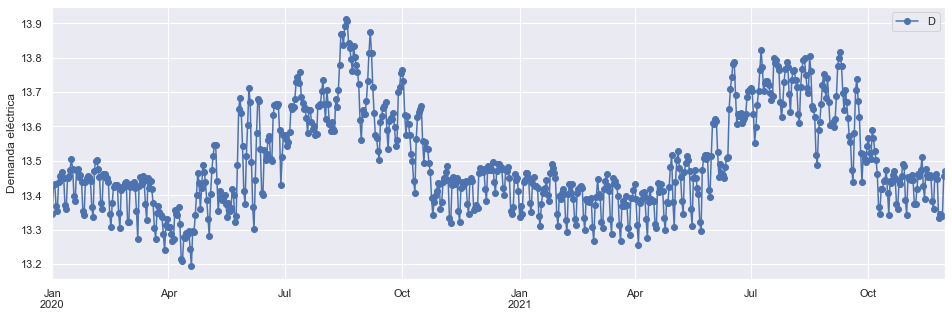

In [47]:
sns.set(rc = {"figure.figsize":(16,5)})
ax = log_DemElec.plot(marker = 'o', linestyle='-')
ax.set_ylabel('Demanda eléctrica');

Utilizaremos esta serie logarítmica para el modelo ARIMA.

In [28]:
log_y_train, log_y_test = temporal_train_test_split(y = log_DemElec, test_size=20)

In [29]:
from sktime.forecasting.arima import AutoARIMA


ARIMA_diario = AutoARIMA(sp=7, suppress_warnings=True)

#  Auto ARIMA Model Estimation
ARIMA_diario.fit(log_y_train)

AutoARIMA(sp=7, suppress_warnings=True)

In [30]:
print(ARIMA_diario.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  680
Model:             SARIMAX(4, 1, 2)x(2, 0, 2, 7)   Log Likelihood                1381.421
Date:                           Thu, 30 Dec 2021   AIC                          -2740.842
Time:                                   11:32:38   BIC                          -2691.115
Sample:                                        0   HQIC                         -2721.592
                                           - 680                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4628      0.332      1.392      0.164      -0.189       1.114
ar.L2          0.3800      0.408      0.932

In [31]:
log_y_pred_ARIMA = ARIMA_diario.predict(fh)
log_y_pred_ARIMA

,D
2021-11-11,13.445617
2021-11-12,13.437108
2021-11-13,13.364093
2021-11-14,13.333128
2021-11-15,13.419764
2021-11-16,13.438768
2021-11-17,13.444018
2021-11-18,13.446388
2021-11-19,13.432515
2021-11-20,13.363064


Mediante la exponencial deshacemos el cambio logarítmico.

In [32]:
np.exp(log_y_pred_ARIMA)

,D
2021-11-11,690808.064832
2021-11-12,684954.404505
2021-11-13,636724.664538
2021-11-14,617310.553341
2021-11-15,673177.312335
2021-11-16,686092.999669
2021-11-17,689703.806698
2021-11-18,691340.820636
2021-11-19,681816.256440
2021-11-20,636070.327510


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

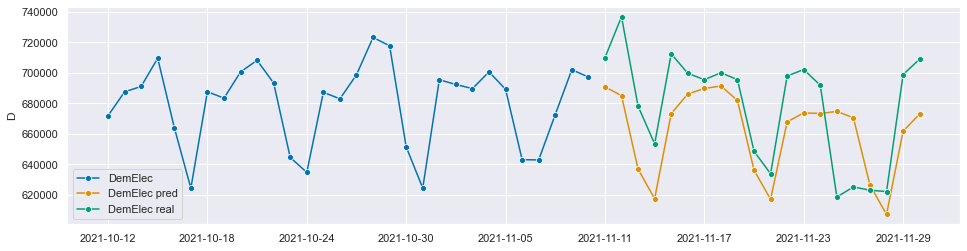

In [33]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train_diario[650:], np.exp(log_y_pred_ARIMA),y_test_diario, labels=["DemElec", "DemElec pred", "DemElec real"])

#### MÉTRICAS

In [34]:
MAPE_ARIMA = mean_absolute_percentage_error(y_test_diario, np.exp(log_y_pred_ARIMA))
MAPE_ARIMA

0.03944652302232897

In [35]:
rmse_ARIMA = MeanSquaredError(square_root=True)
rmse_ARIMA = rmse_ARIMA(y_test_diario, np.exp(log_y_pred_ARIMA))
rmse_ARIMA

30585.06933463166

In [36]:
r2_ARIMA = r2_score(y_test_diario, np.exp(log_y_pred_ARIMA))
r2_ARIMA

0.273358128485812

## MODELO PROPHET

In [37]:
y = datos_diarios["2020":].reset_index(drop=False)
y.columns = ["ds", "y"]
y.tail()

,ds,y
695,2021-11-26,625052
696,2021-11-27,622892
697,2021-11-28,622017
698,2021-11-29,698831
699,2021-11-30,708972


In [38]:
train = y.iloc[:680,:]
test = y.iloc[680:,:]

In [39]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.92105


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1421.53     0.0430041       151.956           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1454.2     0.0060604       124.949      0.3828      0.3828      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1461.22   0.000862616       123.321       1.023      0.2574      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       1462.55   0.000323834       125.705   3.047e-06       0.001      495  LS failed, Hessian reset 
     399       1463.47   0.000479901       54.5395      0.2978           1      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       1463.55   0.000181925       61.7084   2.739e-06       0.001      6

In [40]:
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)

06  LS failed, Hessian reset 
     448       1463.57   5.80713e-05       71.1259   7.882e-07       0.001      679  LS failed, Hessian reset 
     471       1463.58   1.09493e-07       60.3099      0.4945      0.4945      709   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


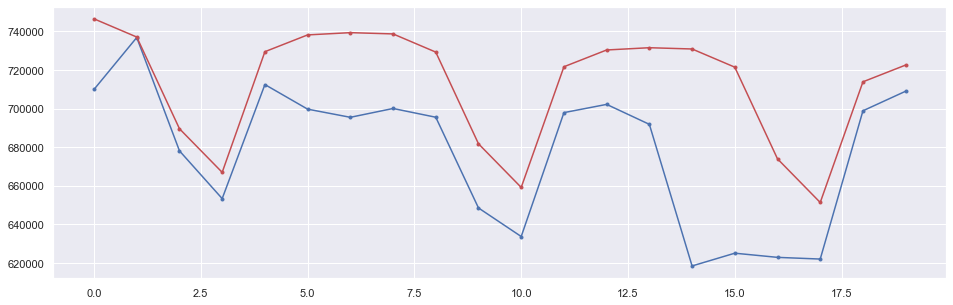

In [41]:
import matplotlib.pyplot as plt
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[680:,'yhat']),'r.-')
plt.show()

#### MÉTRICAS

In [42]:
r2_PROPHET = r2_score(list(test['y']), list(forecast.loc[680:,'yhat']))

In [43]:
MAPE_PROPHET = mean_absolute_percentage_error(test["y"], forecast.loc[680:,'yhat'])
MAPE_PROPHET

0.05099119172903841

In [44]:
rmse_PROPHET = MeanSquaredError(square_root=True)
rmse_PROPHET = rmse_PROPHET(test["y"], forecast.loc[680:,'yhat'])
rmse_PROPHET

43849.88097556672

### RESUMEN MÉTRICAS DE TODOS LOS MODELOS

In [45]:
MAPE = [MAPE_NAIVE, MAPE_ETS, MAPE_ARIMA, MAPE_PROPHET]
RMSE = [rmse_NAIVE, rmse_ETS, rmse_ARIMA, rmse_PROPHET]
R2 = [r2_NAIVE, r2_ETS, r2_ARIMA, r2_PROPHET]
data = {"MAPE": MAPE, "RMSE":RMSE, "R2":R2}
df_metricas = pd.DataFrame(data, columns=["MAPE", "RMSE", "R2"])
df_metricas.index=["Naive", "ETS", "ARIMA", "Prophet"]
df_metricas

,MAPE,RMSE,R2
Naive,0.044742,40109.401605,-0.249666
ETS,0.029598,28807.390870,0.355372
ARIMA,0.039447,30585.069335,0.273358
Prophet,0.050991,43849.880976,-0.493614
